In [ ]:
# Автоматическая перезагрузка модулей при изменении
# Это позволяет обновлять код в helper.py, plots.py, nlp.py без перезапуска ядра
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Импорт необходимых библиотек для анализа данных
import pandas as pd  # для работы с табличными данными
import numpy as np   # для математических операций
import random        # для работы с генератором случайных чисел

# Импорт пользовательских модулей с функциями для анализа
from helper import *  # вспомогательные функции для обработки данных
from plots import *   # функции для визуализации
from nlp import *     # функции для обработки естественного языка


In [ ]:
# Фиксация состояния генератора псевдослучайных чисел для воспроизводимости результатов
# Это критически важно для машинного обучения - результаты должны быть воспроизводимы
SEED = 42 # можно указать любое число
np.random.seed(SEED)  # для numpy операций
random.seed(SEED)     # для стандартного модуля random


## 1. Изучение структуры данных

**Цель:** Понять общую структуру датасета, количество записей, типы данных и качество информации.
Это первый и самый важный этап любого анализа данных - без понимания структуры невозможно корректно проводить дальнейшую обработку.


In [ ]:
# Загружаем предобработанные данные из CSV файла
# Датасет содержит информацию о вакансиях с их описаниями и метками
df = pd.read_csv('data/data_preprocessed.csv')


In [ ]:
# Выводим общую информацию о структуре датасета:
# - количество записей (1624)
# - количество столбцов (4)
# - типы данных в каждом столбце
# - количество пропущенных значений (в данном случае - отсутствуют)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1624 entries, 0 to 1623
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       1624 non-null   int64 
 1   description      1624 non-null   object
 2   title            1624 non-null   object
 3   is_data_science  1624 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 50.9+ KB


## 2. Проверка на корректность и качество данных

**Цель:** Выявить проблемы с данными, которые могут повлиять на качество анализа и моделирования.
Проверяем на дубликаты, пропущенные значения и аномальные записи.


### 2.1 Проверка на дубликаты

**Логика:** Дублированные записи могут искажать результаты анализа и обучения модели.
Если одна и та же вакансия встречается несколько раз, это может привести к переобучению.


In [ ]:
# Подсчет числа полностью дублированных строк
# Результат: 0 означает, что дубликатов нет - это хорошо для качества данных
df.duplicated().sum()


0

### 2.2 Пропущенные значения

**Логика:** Пропущенные значения могут нарушить работу алгоритмов машинного обучения.
Нужно понять, есть ли пропуски и как они распределены по столбцам.


In [ ]:
# Выводим число пропущенных значений по каждому столбцу
# Результат: все значения равны 0, что означает отсутствие пропусков - отличное качество данных
df.isnull().sum()


Unnamed: 0         0
description        0
title              0
is_data_science    0
dtype: int64

In [ ]:
# Анализ коротких описаний (менее 300 символов)
# Короткие описания могут быть неинформативными или содержать служебную информацию
short_texts = df[df['description'].str.len() < 300]
short_texts['description'].value_counts()


description
Unknown    5
Name: count, dtype: int64

In [ ]:
# Удаляем строки с описанием "Unknown" - это неинформативные записи
# Такие записи не несут смысловой нагрузки для классификации
df = df[df['description'] != 'Unknown']


In [ ]:
# Анализ длинных заголовков (более 100 символов)
# Слишком длинные заголовки могут содержать избыточную информацию или быть некорректными
long_titles = df[df['title'].str.len() > 100]
long_titles['title'].value_counts()


title
(Senior) ML Engineer / Software Engineer Machine Learning & AI (m/f/x) onsite or remote (in Germany or Austria)                                       2
Software Developer - €100,000 – Spring Boot, Cloud, Microservices - Greenfield - Build a new product!                                                 1
Associate (f/m/d) Advanced Analytics & Artificial Intelligence focus Data Engineering and Cloud Architecture                                          1
PhD student (m/f/d) | Developing and implementating of machine learning applications and data analysis in Translational Psychiatry                    1
Software Developer – Java17, Spring Boot, Angular/Ember, PostgreSQL, GCP, Kubernetes – Remote - €80,000                                               1
Student Internship IP2TIS 2024 - Adverse media in social due diligence: for Data Scientists, Business Informatics or Computer Science Students        1
Deep Learning Engineer for Camera-LiDAR based Multimodal Perception (m/f/d) - Qual

## 3. Детальное изучение признаков (и таргета)

**Цель:** Глубокий анализ каждого признака для понимания их информативности и распределения.
Это поможет выбрать правильные методы предобработки и понять, какие признаки наиболее важны для классификации.


In [ ]:
# Создаем копию датасета для EDA, чтобы не изменять исходные данные
# Это позволяет безопасно экспериментировать с данными
df_EDA = df.copy()


### 3.1. Таргет (целевая переменная)

**Логика:** Анализ распределения целевой переменной критически важен для понимания задачи.
Нужно проверить баланс классов - если один класс сильно преобладает, это может потребовать специальных подходов.


In [17]:
# Анализируем распределение целевой переменной (is_data_science)
# 0 - не data science вакансия, 1 - data science вакансия
# Смотрим, насколько сбалансированы классы
df_EDA['is_data_science'].value_counts()


is_data_science
0    971
1    648
Name: count, dtype: int64

### 3.2. Анализ заголовков (Title)

**Логика:** Заголовки вакансий часто содержат ключевую информацию о специальности.
Анализируем длину, частотность слов и их важность для классификации.


In [ ]:
# Создаем признак длины заголовка в символах
# Длина текста может быть важным признаком для классификации
df_EDA['title_char_length'] = df_EDA['title'].str.len()


In [ ]:
# Статистическое описание длины заголовков
# Видим среднюю, минимальную, максимальную длину и квартили
df_EDA['title_char_length'].describe()


count    1619.000000
mean       38.599753
std        19.494550
min         6.000000
25%        24.000000
50%        34.000000
75%        51.000000
max       146.000000
Name: title_char_length, dtype: float64

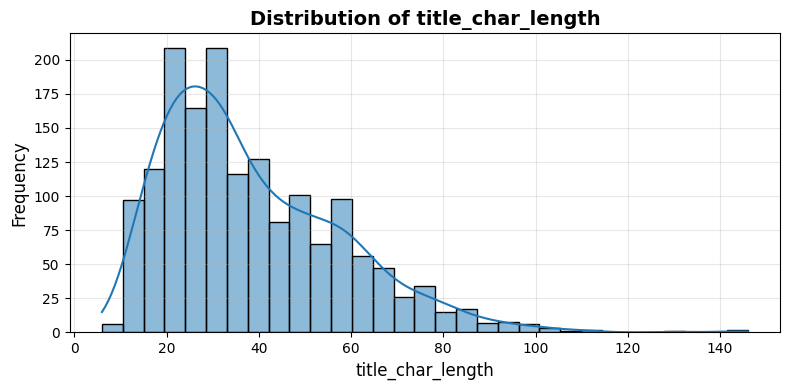

In [ ]:
# Визуализируем распределение длины заголовков
# Гистограмма поможет понять, как распределена длина текстов
plot_hist_numeric(df_EDA, 'title_char_length')


In [ ]:
# Токенизация заголовков с помощью tiktoken (токенизатор GPT)
# Tiktoken лучше работает с техническими терминами, чем стандартные токенизаторы
df_EDA['title_tokenized_tiktoken'] = df_EDA['title'].apply(tokenize_tiktoken)
df_EDA['title_tokenized_tiktoken_len'] = df_EDA['title_tokenized_tiktoken'].apply(len)


In [ ]:
# Подсчет частотности токенов в заголовках
# Удаляем стоп-слова и пунктуацию, приводим к нижнему регистру для корректного подсчета
# Это поможет выявить наиболее частые слова в заголовках
title_token_counts = token_counts(
    df_EDA, 
    'title_tokenized_tiktoken', 
    remove_stopwords=True, 
    remove_punctuation=True,
    lowercase_for_counting=True
)


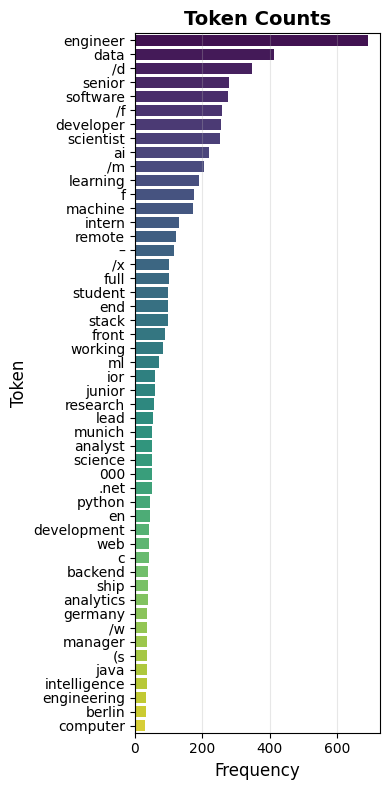

In [23]:
# Визуализация топ-50 самых частых токенов в заголовках
# Столбчатая диаграмма поможет быстро увидеть ключевые слова
barplot(
    title_token_counts, 
    title='Token Counts', 
    ylabel='Token', 
    top_n=50, 
    figsize=(4, 8)
)


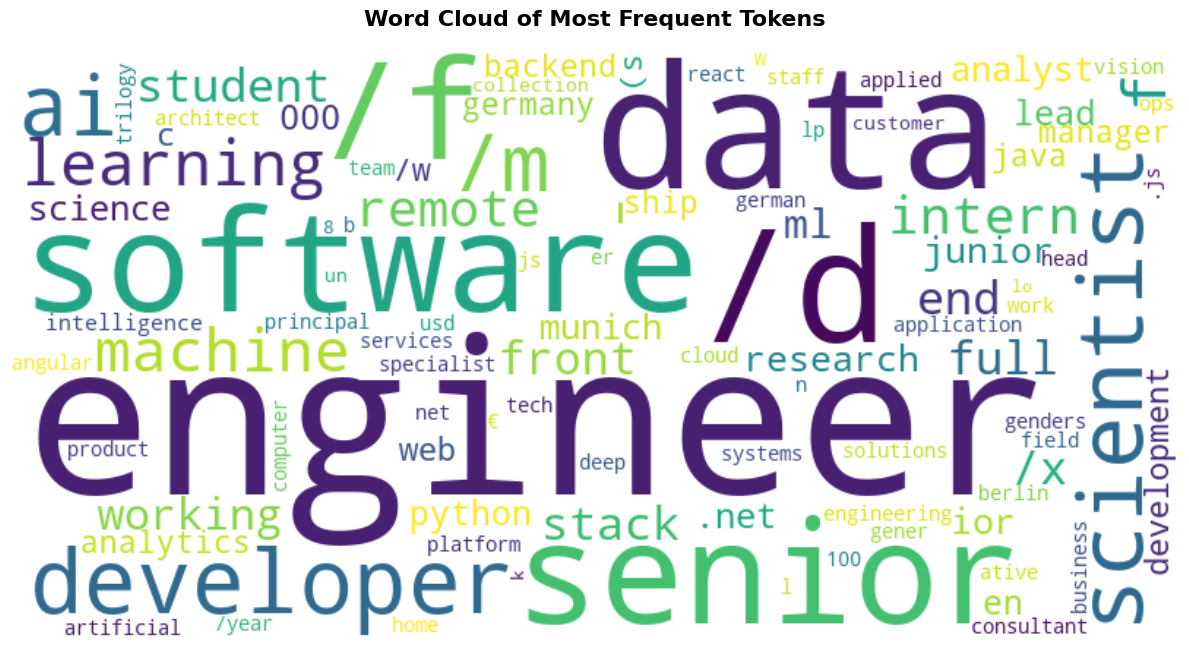

In [ ]:
# Облако слов для визуализации частотности токенов
# Размер слова пропорционален его частотности - интуитивно понятная визуализация
plot_wordcloud(
    title_token_counts, 
    title='Word Cloud of Most Frequent Tokens', 
    max_words=100
)


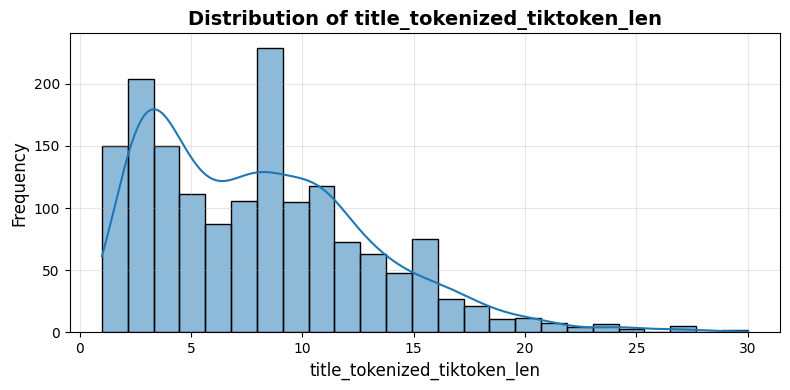

In [ ]:
# Распределение количества токенов в заголовках
# Помогает понять, сколько слов в среднем содержит заголовок
plot_hist_numeric(df_EDA, 'title_tokenized_tiktoken_len')


In [ ]:
# Очистка токенов: удаляем стоп-слова и знаки пунктуации
# Это подготовка для анализа важности токенов для классификации
df_EDA['title_tokenized_tiktoken_clean'] = df_EDA['title_tokenized_tiktoken'].apply(lambda tokens: filter_tokens(
    tokens, 
    remove_stopwords=True, 
    remove_punct_tokens=True,
    lowercase_for_counting=True
))


In [ ]:
# Анализ важности токенов для классификации с помощью ANOVA F-test
# n=3: анализируем 1-граммы, 2-граммы и 3-граммы
# min_count=50: учитываем только токены, встречающиеся минимум 50 раз
# Это поможет выявить наиболее информативные для классификации слова и фразы
title_token_counts = count_based_analysis(
    texts_tokenized = df_EDA['title_tokenized_tiktoken_clean'], 
    labels = df_EDA['is_data_science'], 
    n=3,
    metric='anova_f',
    min_count=50
)


In [ ]:
# Выводим топ-5 наиболее важных для классификации токенов в заголовках
# Чем выше значение метрики, тем важнее токен для различения классов
title_token_counts.head(5)


,token,metric,count_0,freq_0,count_1,freq_1,total_count
0,data scientist,465.764257,2,0.000134,214,0.023370,216
1,scientist,444.429761,18,0.001202,235,0.025663,253
2,data,197.148617,126,0.008413,288,0.031451,414
3,learning,196.089231,29,0.001936,161,0.017582,190
4,machine,184.160397,25,0.001669,147,0.016053,172


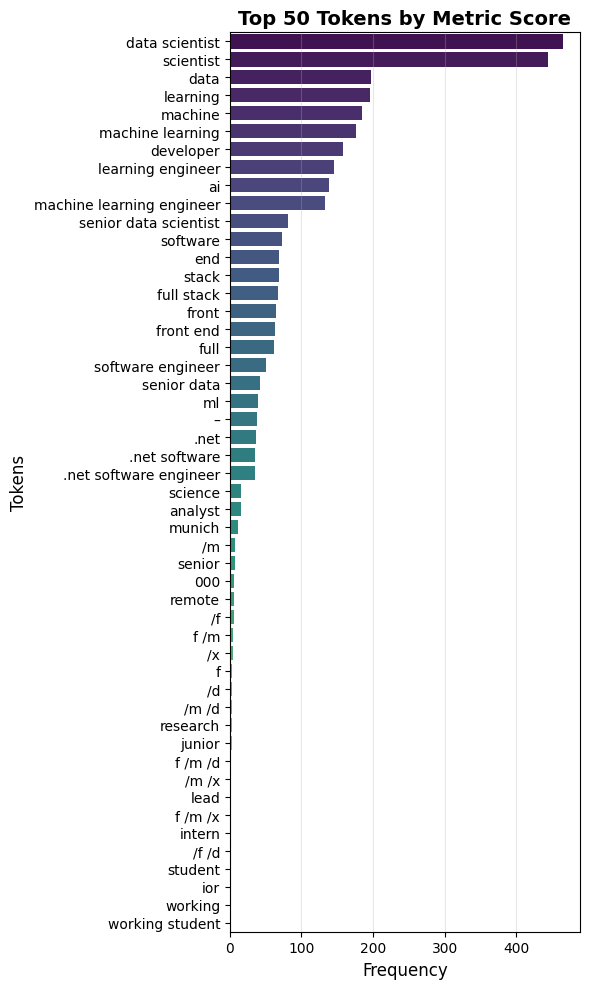

In [ ]:
# Визуализация топ-50 токенов по важности для классификации
# Помогает понять, какие слова и фразы лучше всего различают DS и не-DS вакансии
barplot_data_metric = title_token_counts.set_index('token')['metric'].head(50)
barplot(barplot_data_metric, 'Top 50 Tokens by Metric Score', 'Tokens', figsize=(6, 10))


### 3.3. Анализ описаний (Description)

**Логика:** Описания вакансий содержат основную информацию о требованиях и обязанностях.
Это самый информативный признак для классификации, поэтому его анализ особенно важен.


In [ ]:
# Анализ длины описаний в символах
# Описания обычно длиннее заголовков и содержат больше информации
df_EDA['description_char_length'] = df_EDA['description'].str.len()


In [31]:
# Статистическое описание длины описаний
# Описания значительно длиннее заголовков, что ожидаемо
df_EDA['description_char_length'].describe()


count     1619.000000
mean      3532.260655
std       1681.893777
min        380.000000
25%       2251.500000
50%       3290.000000
75%       4570.000000
max      11837.000000
Name: description_char_length, dtype: float64

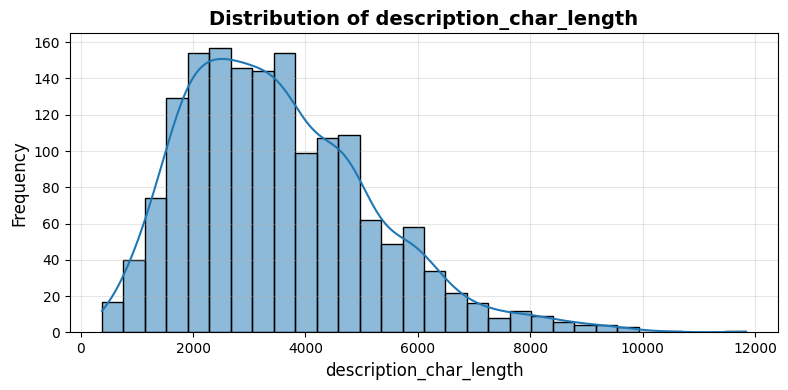

In [32]:
# Распределение длины описаний
# Видим, что большинство описаний довольно длинные (более 1000 символов)
plot_hist_numeric(df_EDA, 'description_char_length')


In [ ]:
# Токенизация описаний
# Описания содержат больше токенов, чем заголовки
df_EDA['description_tokenized_tiktoken'] = df_EDA['description'].apply(tokenize_tiktoken)
df_EDA['description_tokenized_tiktoken_len'] = df_EDA['description_tokenized_tiktoken'].apply(len)


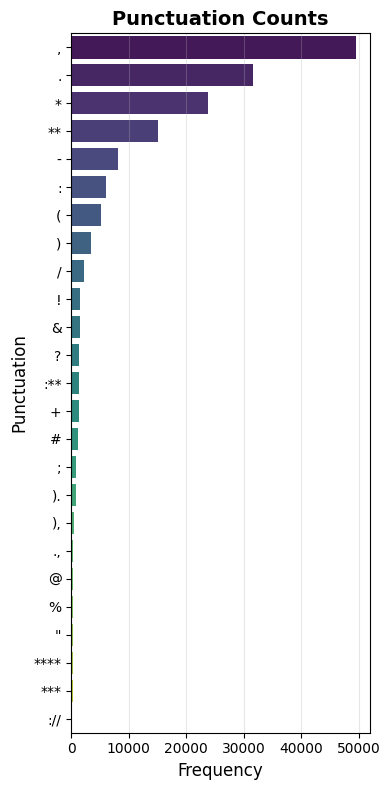

In [34]:
# Анализ знаков пунктуации в описаниях
# Многие описания в markdown формате, поэтому знаки пунктуации могут быть информативными
punctuation_counts = punctuation_counts(df_EDA, 'description_tokenized_tiktoken')
barplot(punctuation_counts, title='Punctuation Counts', ylabel='Punctuation', top_n=25, figsize=(4, 8))


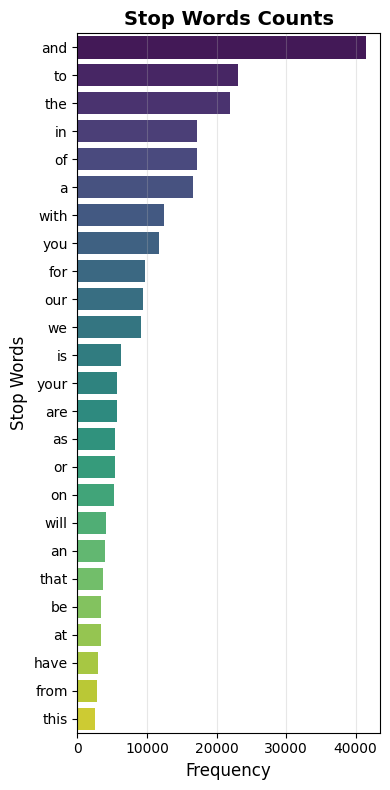

In [ ]:
# Анализ стоп-слов в описаниях
# Стоп-слова (артикли, предлоги, союзы) обычно удаляются при обработке текста
stop_words_counts = stopwords_count(df_EDA, 'description_tokenized_tiktoken')
barplot(stop_words_counts, title='Stop Words Counts', ylabel='Stop Words', top_n=25, figsize=(4, 8))


In [ ]:
# Подсчет частотности токенов в описаниях (без стоп-слов и пунктуации)
# Это поможет выявить ключевые технические термины и навыки
token_counts = token_counts(
    df_EDA, 
    'description_tokenized_tiktoken', 
    remove_stopwords=True, 
    remove_punctuation=True,
    lowercase_for_counting=True
)


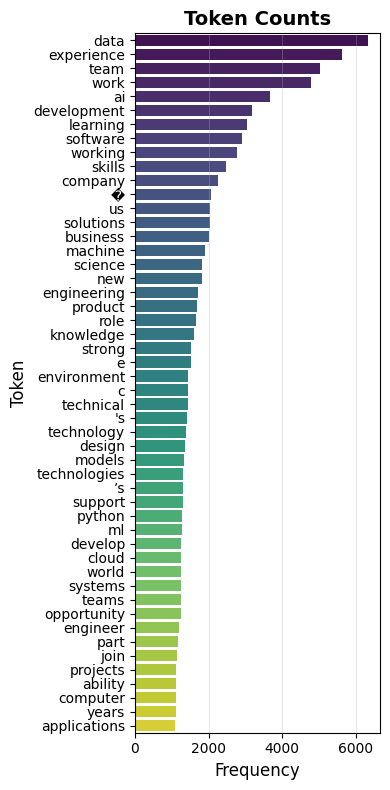

In [ ]:
# Топ-50 самых частых токенов в описаниях
# Видим технические термины, языки программирования, инструменты
barplot(token_counts, title='Token Counts', ylabel='Token', top_n=50, figsize=(4, 8))


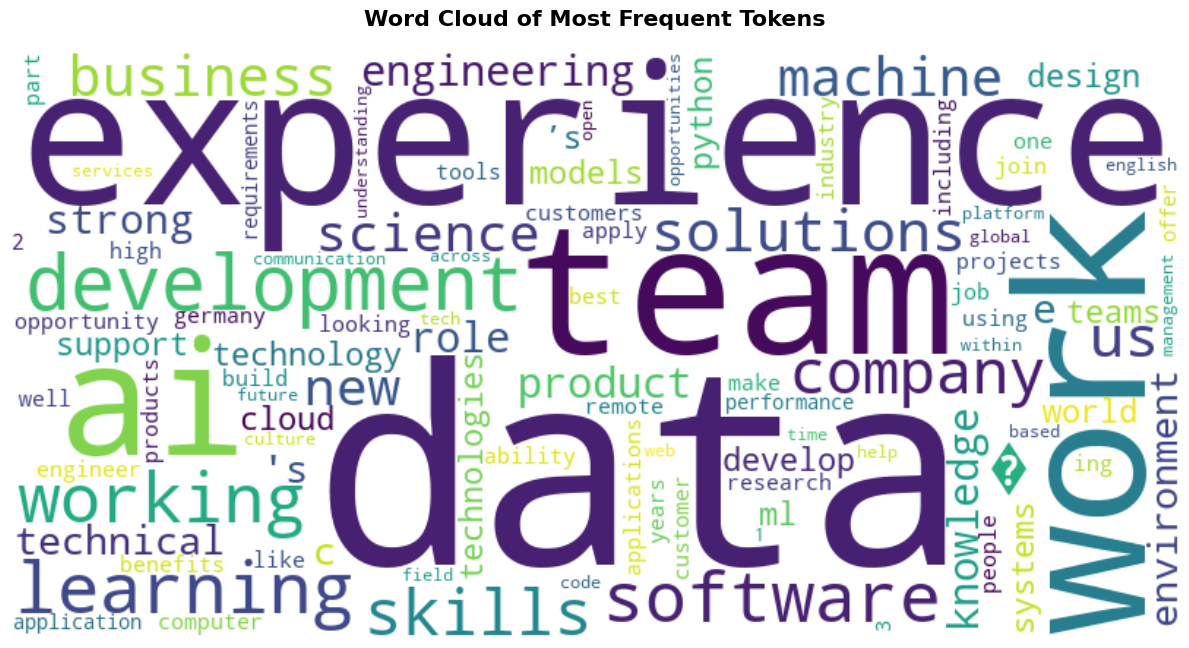

In [ ]:
# Облако слов для описаний
# Визуально показывает, какие технологии и навыки чаще всего упоминаются
plot_wordcloud(token_counts, title='Word Cloud of Most Frequent Tokens', max_words=100)


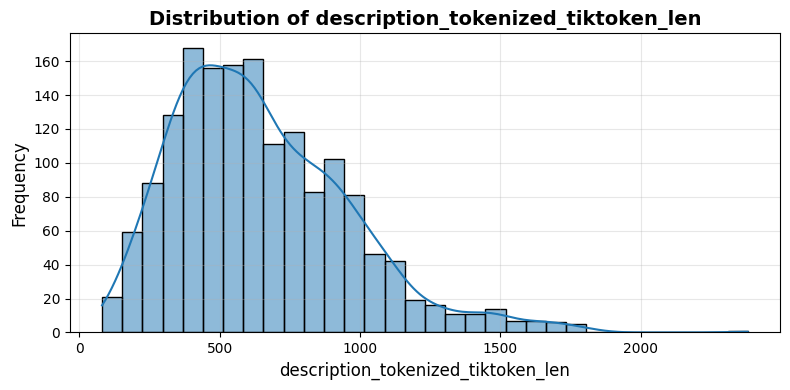

In [ ]:
# Распределение количества токенов в описаниях
# Описания содержат значительно больше токенов, чем заголовки
plot_hist_numeric(df_EDA, 'description_tokenized_tiktoken_len')


In [ ]:
# Очистка токенов описаний: удаляем стоп-слова и пунктуацию
# Подготавливаем данные для анализа важности токенов
df_EDA['description_tokenized_tiktoken_clean'] = df_EDA['description_tokenized_tiktoken'].apply(lambda tokens: filter_tokens(
    tokens, 
    remove_stopwords=True, 
    remove_punct_tokens=True,
    lowercase_for_counting=True
))


In [ ]:
# Анализ важности токенов в описаниях для классификации
# Это самый важный анализ - выявляем, какие слова и фразы лучше всего различают DS и не-DS вакансии
# n=3: анализируем 1-граммы, 2-граммы и 3-граммы
counts = count_based_analysis(
    texts_tokenized = df_EDA['description_tokenized_tiktoken_clean'], 
    labels = df_EDA['is_data_science'], 
    n=3,
    metric='anova_f',
    min_count=50
)


In [ ]:
# Настраиваем отображение чисел с плавающей точкой для лучшей читаемости
pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [ ]:
# Выводим результаты анализа важности токенов
# Чем выше значение метрики, тем важнее токен для классификации DS vs не-DS вакансий
counts


,token,metric,count_0,freq_0,count_1,freq_1,total_count
0,machine,463.20126,382,0.00038,1526,0.00203,1908
1,machine learning,456.76872,345,0.00034,1471,0.00196,1816
2,models,415.58130,274,0.00027,1060,0.00141,1334
3,learning,376.92387,813,0.00080,2230,0.00296,3043
4,science,270.96564,593,0.00058,1231,0.00164,1824
...,...,...,...,...,...,...,...
2824,media,0.00002,84,0.00008,56,0.00007,140
2825,result,0.00001,39,0.00004,26,0.00003,65
2826,internally,0.00001,33,0.00003,22,0.00003,55
2827,numerous,0.00001,36,0.00004,24,0.00003,60


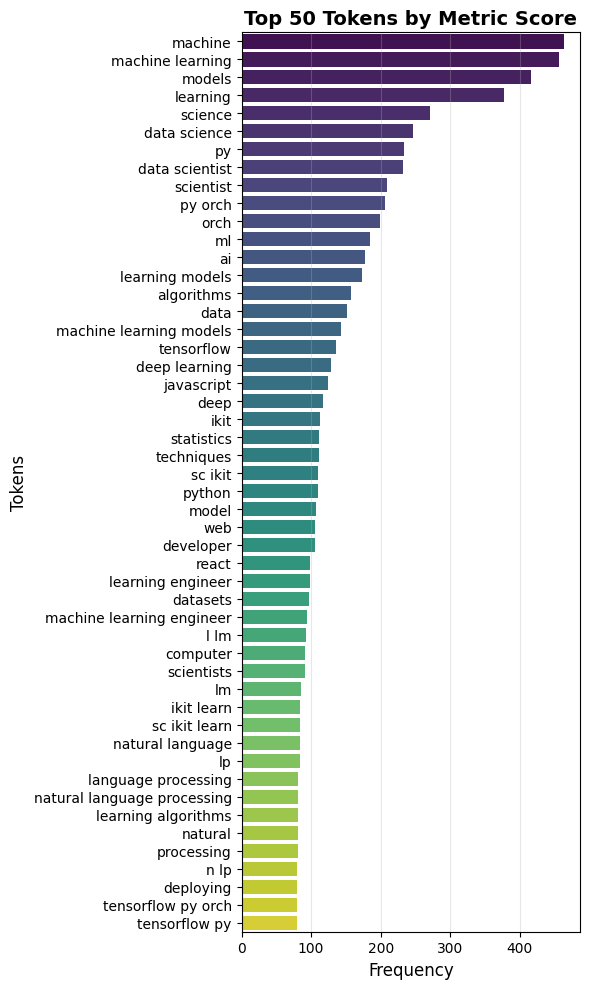

In [ ]:
# Визуализация топ-50 наиболее важных для классификации токенов в описаниях
# Это ключевой результат EDA - показывает, какие термины лучше всего различают типы вакансий
barplot_data_metric = counts.set_index('token')['metric'].head(50)
barplot(barplot_data_metric, 'Top 50 Tokens by Metric Score', 'Tokens', figsize=(6, 10))
